# Still Working on Tuning Confidence Bounds

In [167]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

In [213]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0

def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim

class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState

    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0

    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd

    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [245]:
class LSVI_UCB(object):
    def __init__(self,env,K):
        self.env = env
        self.K = K
        self.d = self.env.nState * self.env.nAction
        self.lam = 1.0
        self.Lambda = {h: self.lam*np.identity(self.d) for h in range(self.env.epLen)}
        self.Linv = {h: (1/self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.w = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        self.features_state_action = {(s,a): np.zeros(self.d) for s in self.env.states.keys() \
                                      for a in range(self.env.nAction)}
        self.createIdentity()
        self.buffer = {h: [] for h in range(self.env.epLen)}
        self.sums = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.p = 1/self.K
        self.c = 0.1
        
    
    def createIdentity(self):
        '''
            A function that creates the Identity Matrix for a Dictionary
        '''
        i = 0
        for key in self.features_state_action.keys():
            self.features_state_action[key][i] = 1
            i += 1
        j = 0
    
    def update_buffer(self,s,a,r,s_,h):
        self.buffer[h].append((s,a,r,s_))
    
    def reset_buffer(self):
        self.buffer = {h: [] for h in range(self.env.epLen)}
    
    def update(self):
        
        Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        for h in range(self.env.epLen-1,-1,-1):
            d = self.buffer[h]
            s,a,r,s_ = d[0][0],d[0][1],d[0][2],d[0][3]
            
            self.Linv[h] = self.Linv[h] - np.dot((np.outer(np.dot(self.Linv[h],self.features_state_action[s,a]) \
                 ,self.features_state_action[s,a])),self.Linv[h]) / \
                    (1 + np.dot(np.dot(self.features_state_action[s,a],self.Linv[h]),self.features_state_action[s,a]))
            
            self.sums[h] = self.sums[h] + self.features_state_action[s,a]*(env.R[s,a][0] + \
                                             max(np.array([Q[(h+1,s_,a)] for a in range(self.env.nAction)])))
            
            self.w[h] = np.matmul(self.Linv[h],self.sums[h])
            for ss in self.env.states.keys():
                for aa in range(env.nAction):
                    feature = self.features_state_action[ss,aa]
                    Q[h,ss,aa] = min(env.R[ss,aa][0] + np.inner(self.w[h],feature) + self.Beta() \
                                    * np.sqrt(np.dot(np.dot(feature,self.Linv[h]),feature)),self.env.epLen)
        self.Q = Q.copy()
    
    def act(self,s,h):
        '''
        A function that returns the argmax of Q given the state and timestep
        '''
        return self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
                    
    
    def Beta(self):
        iota = np.log(2*self.d*self.K*self.env.epLen/self.p)
        return np.sqrt(self.c * self.d * self.env.epLen * np.sqrt(iota))
        
        

In [246]:
env = make_riverSwim(epLen = 10, nState = 3)
K = 5000
agent = LSVI_UCB(env,K)
R = 0
Rvec = []

In [247]:
for k in tqdm(range(1,K+1)):
    env.reset()
    done = 0
    while not done:
        s = env.state
        h = env.timestep
        a = agent.act(s,h)
        if k == K: print(a)
        r,s_,done = env.advance(1)
        agent.update_buffer(s,a,r,s_,h)
        R += r
    Rvec.append(R)
    agent.update()
    agent.reset_buffer()

1
1
0
1
1
0
1
0
1
1



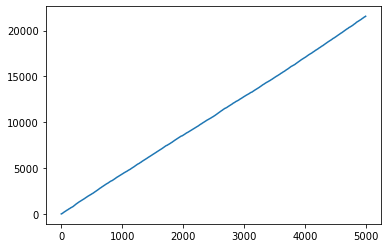

In [248]:
plt.plot(Rvec)

In [249]:
agent.Q

{(0, 0, 0): 5.299179434596923,
 (0, 0, 1): 10,
 (0, 1, 0): 5.2941794345969235,
 (0, 1, 1): 5.2941794345969235,
 (0, 2, 0): 5.2941794345969235,
 (0, 2, 1): 6.2941794345969235,
 (1, 0, 0): 10,
 (1, 0, 1): 5.2941794345969235,
 (1, 1, 0): 5.2941794345969235,
 (1, 1, 1): 10,
 (1, 2, 0): 5.2941794345969235,
 (1, 2, 1): 6.2941794345969235,
 (2, 0, 0): 9.624977156874268,
 (2, 0, 1): 5.2941794345969235,
 (2, 1, 0): 9.724551870090338,
 (2, 1, 1): 5.2941794345969235,
 (2, 2, 0): 5.2941794345969235,
 (2, 2, 1): 10,
 (3, 0, 0): 8.695293658048357,
 (3, 0, 1): 5.2941794345969235,
 (3, 1, 0): 5.2941794345969235,
 (3, 1, 1): 9.07648328458006,
 (3, 2, 0): 5.2941794345969235,
 (3, 2, 1): 10,
 (4, 0, 0): 7.3646320828316725,
 (4, 0, 1): 5.2941794345969235,
 (4, 1, 0): 5.2941794345969235,
 (4, 1, 1): 7.87120628943083,
 (4, 2, 0): 5.2941794345969235,
 (4, 2, 1): 10,
 (5, 0, 0): 5.528327455227263,
 (5, 0, 1): 5.2941794345969235,
 (5, 1, 0): 6.456081064176807,
 (5, 1, 1): 5.2941794345969235,
 (5, 2, 0): 8.6391

In [195]:
print(a)

0
